In [1]:
import glob
import numpy as np
import hyss_util as hu
from datetime import datetime
from sklearn.decomposition import PCA, FactorAnalysis, FastICA
from sklearn.model_selection import train_test_split
from plotting import set_defaults
import pandas as pd
from pandas.plotting import scatter_matrix
import scipy as sp
from scipy import stats
from scipy import signal
from scipy.optimize import minimize
from scipy.ndimage import gaussian_filter1d
import statsmodels.formula.api as sm
import random
import emcee
import corner
from IPython.display import display, Math
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# -- set the types

kind = "veg"
comp = "bld"
runpca = False
runfan = False
runica = False
getndvi = False

In [3]:
# -- get wavelengths
waves = hu.read_header("../../../image_files/veg_00000.hdr")["waves"]

# -- define good scans
good = np.array([int(i) for i in np.load("../../../gdobler_output/output/good_scans.npy")])

reading and parsing ../../../image_files/veg_00000.hdr...


In [4]:
# -- get vegetation spectra
print("getting {0} spectra...".format(kind))
if kind=="veg":
    vegs = np.load("../../../gdobler_output/output/veg_patch_specs.npy")
else:
    vegs = np.array([np.load(i) for i in
                     sorted(glob.glob("../../../gdobler_output/output/" + 
                                      "{0}_specs/{0}_specs_avg*.npy" \
                                      .format(kind)))])
    vegs = vegs[good]

getting veg spectra...


In [5]:
# -- load comparison set from bld
print("getting {0} spectra...".format(comp))
#try:
#    blds_left = np.load("../../../gdobler_output/output/blds_left.npy")
#except:
blds = np.array([np.load(i) for i in
                sorted(glob.glob("../../../gdobler_output/output/{0}_specs/{0}_specs_avg*.npy"\
                                .format(comp)))])
blds = blds[good]
# np.save("../../../gdobler_output/output/blds_left.npy",blds)

getting bld spectra...


In [6]:
# -- produce coordinates to radomly split building block
rr = np.arange(44)  # rows
rc = np.arange(157) # columns
coords = np.zeros((44*157, 2)).astype(np.uint8)
n = 0
for i in range(44):
    for j in range(157):
        coords[n] = (rr[i], rc[j])
        n += 1
np.random.seed(10)
np.random.shuffle(coords)
indleft, indright = np.split(coords, 2)
print(indleft.shape)
print(indright.shape)

(3454, 2)
(3454, 2)


In [7]:
cube = hu.read_hyper("../../../image_files/veg_00108.raw")
waves = hu.read_header("../../../image_files/veg_00108.hdr")["waves"]

reading and parsing ../../../image_files/veg_00108.hdr...
reading ../../../image_files/veg_00108.raw...
reading and parsing ../../../image_files/veg_00108.hdr...


In [8]:
lam = [610.,540.,475.]
bands = [np.arange(waves.size)[(waves>=(tlam-10.))&(waves<(tlam+10.))] for
        tlam in lam]
red = cube.data[bands[0]].mean(0)
grn = cube.data[bands[1]].mean(0)
blu = cube.data[bands[2]].mean(0)
red8 = red*2.**8/2.**12
grn8 = grn*2.**8/2.**12
blu8 = blu*2.**8/2.**12
wr = red.mean()
wg = grn.mean()
wb = blu.mean()
scl = np.array([wr,wg,wb])
scl /= scl.max()
scl /= np.array([0.9,1.0,1.0])
amp=1.5
rgb8 = (amp*np.dstack([red8,grn8,blu8])/scl).clip(0,255).astype(np.uint8)
plt_blds = rgb8[990:1034,799:956]

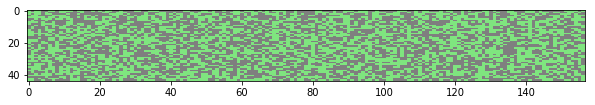

In [9]:
bld_l = np.zeros((plt_blds.shape[0], plt_blds.shape[1], 4))
bld_r = np.zeros((plt_blds.shape[0], plt_blds.shape[1], 4))
bld_l[indleft[:,0],indleft[:,1],:] = np.array([0.5,0.5,0.5,1])
bld_r[indright[:,0],indright[:,1],:] = np.array([0.5,0.9,0.5,1])
fig, ax = plt.subplots(figsize=[10,5])
im  = ax.imshow(plt_blds, aspect=0.45, interpolation="nearest")
iml = ax.imshow(bld_l, aspect=0.45, interpolation="nearest")
imr = ax.imshow(bld_r, aspect=0.45, interpolation="nearest")
fig.canvas.draw()

In [10]:
# -- load comparison set from bld (left box)
print("getting {0} spectra...".format(comp))
#try:
#    blds_left = np.load("../../../gdobler_output/output/blds_left.npy")
#except:
blds_left = np.array([np.load(i)[:,indleft[:,0],indleft[:,1]].mean(-1).mean(-1) for i in
                sorted(glob.glob("../../../gdobler_output/output/{0}_specs/{0}_specs*.npy"\
                                .format(comp))) if "_avg" not in i])
blds_left = blds_left[good]
    # np.save("../../../gdobler_output/output/blds_left.npy",blds)

getting bld spectra...


In [11]:
# -- get comparison spectra from right building
print("getting {0} spectra...".format(comp))
#try:
#    blds_right = np.load("../../../gdobler_output/output/blds_right.npy")
#except:
blds_right = np.array([np.load(i)[:,indright[:,0],indright[:,1]].mean(-1).mean(-1) for i in
                 sorted(glob.glob("../../../gdobler_output/output/{0}_specs/{0}_specs*.npy"\
                                      .format(comp))) if "_avg" not in i])
blds_right = blds_right[good]
    # np.save("../../../gdobler_output/output/blds_right.npy",vegs)

getting bld spectra...


In [12]:
def normalize_spectra(specs):
    ms, bs = [], []
    for ii in range(specs.shape[0]):
        m = specs[0].mean()/specs[ii].mean()
        b = 0.0
        ms.append(m)
        bs.append(b)
        
    ms   = np.array(ms)
    bs   = np.array(bs)
    norm = specs*ms[:,np.newaxis] + bs[:,np.newaxis]
    rat  = norm/norm[0]
    return rat

In [13]:
# -- normalize spectra

vrat = normalize_spectra(vegs)
brat = normalize_spectra(blds)
rbrat = normalize_spectra(blds_right)
lbrat = normalize_spectra(blds_left)

In [14]:
# -- take the ratio of ratios
D_vrat = vrat/brat   # vegetation to left buildings
D_brat = rbrat/lbrat  # right buildings to left buildings

In [15]:
print(waves[500], waves[-150])
print(waves[430], waves[570])

ind_ir  = np.argmin(np.abs(waves-860.))
ind_vis = np.argmin(np.abs(waves-670.))

749.76 895.9
698.89 801.05


In [16]:
# calculate differential ratios
# D(750)/D(1000)

Dveg = D_vrat[:,500] / D_vrat[:,-1]
Dbld = D_brat[:,500] / D_brat[:,-1]

In [41]:
# normalize differential ratios

Dn_veg = stats.zscore(Dveg)
#Dn_bld = stats.zscore(Dbld)
Dn_bld = Dbld - Dbld.mean()

#### Normalize and plot air quality

In [29]:
# -- get some ancillary data
sc     = pd.read_csv("../../../gdobler_output/output/scan_conditions.csv")
sc_sub = sc[sc.filename.isin(["veg_{0:05}.raw".format(i) for i in good])]

temps = sc_sub.temperature.values
humid = sc_sub.humidity.values
pm25  = sc_sub.pm25.values
o3    = sc_sub.o3.values
secs  = []
for stime in sc_sub.time.values:
    yr, mo, dy, tm = stime.split()
    stime_fmt      = "{0} {1} {2:02} {3}:00".format(yr,mo,int(dy),tm)
    obs_dt         = datetime.strptime(stime_fmt,"%Y %b %d %H:%M:%S")
    secs.append(float(obs_dt.strftime("%s")))
secs = np.array(secs)

In [30]:
# create air quality arrays

#normalize air quality arrays

o3 = stats.zscore(o3)
pm25 = stats.zscore(pm25)
temps = stats.zscore(temps)
humid = stats.zscore(humid)

aq_opth1  = np.vstack([o3,pm25,temps,humid,np.ones_like(o3)]).T
aq_pth1 = np.vstack([pm25,temps,humid,np.ones_like(o3)]).T
aq_op1 = np.vstack([o3,pm25,np.ones_like(o3)]).T

In [31]:
opth = pd.DataFrame({'O3': o3, 'PM2.5': pm25, 'Temp': temps, 'Humidity':humid})
opth.describe()

,Humidity,O3,PM2.5,Temp
count,1.102000e+03,1.102000e+03,1.102000e+03,1.102000e+03
mean,2.579102e-17,-2.579102e-17,1.805372e-16,8.253128e-16
std,1.000454e+00,1.000454e+00,1.000454e+00,1.000454e+00
min,-1.419953e+00,-2.240910e+00,-1.844136e+00,-2.099002e+00
25%,-8.365119e-01,-8.240281e-01,-7.389396e-01,-6.694621e-01
50%,-2.919674e-01,1.244428e-02,-1.733975e-01,1.671688e-02
75%,7.971218e-01,5.587119e-01,5.955698e-01,6.838353e-01
max,1.730627e+00,3.290050e+00,3.139429e+00,2.437404e+00


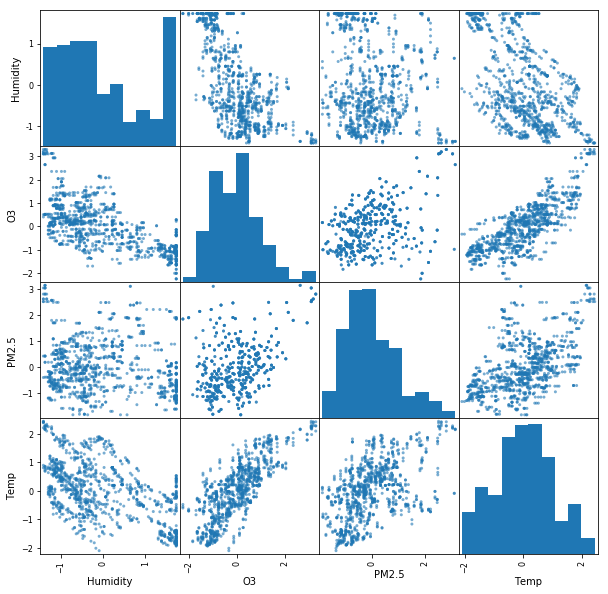

In [32]:
scatter_matrix(opth, alpha=0.6, figsize=(10,10), diagonal='hist')
plt.show()

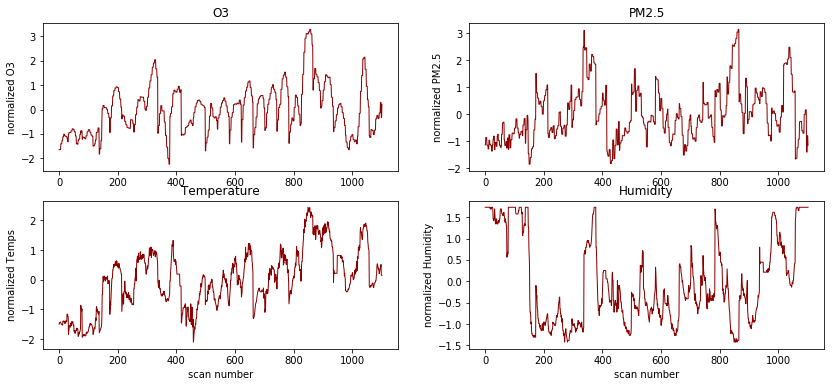

In [33]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14,6))

ax1.plot(o3,color="darkred",lw=1)
#ax1.set_xlabel("scan number")
ax1.set_ylabel('normalized O3')
ax1.set_title('O3')

ax2.plot(pm25,color="darkred",lw=1)
#ax2.set_xlabel("scan number")
ax2.set_ylabel('normalized PM2.5')
ax2.set_title('PM2.5')

ax3.plot(temps,color="darkred",lw=1)
ax3.set_xlabel("scan number")
ax3.set_ylabel('normalized Temps')
ax3.set_title('Temperature')

ax4.plot(humid,color="darkred",lw=1)
ax4.set_xlabel("scan number")
ax4.set_ylabel('normalized Humidity')
ax4.set_title('Humidity')

plt.show()

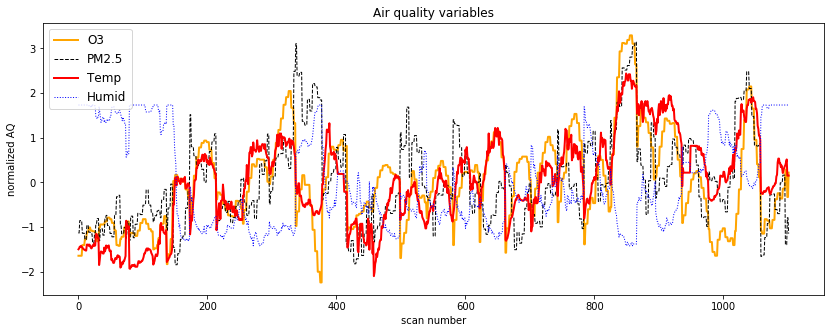

In [34]:
fig = plt.subplots(figsize=[14,5])
lino, = plt.plot(o3, color="orange", lw=2)
linp, = plt.plot(pm25, color="black", lw=1, ls='dashed')
lint, = plt.plot(temps, color="red", lw=2)
linh, = plt.plot(humid, color="blue", lw=1, ls='dotted')
plt.title("Air quality variables")
plt.xlabel("scan number")
plt.ylabel("normalized AQ")
plt.legend([lino,linp,lint,linh], ["O3","PM2.5","Temp","Humid"], loc="upper left", fontsize=12)
plt.show()

In [35]:
aq_opth1  = np.vstack([o3,pm25,temps,humid,np.ones_like(o3)]).T

## (1)  D(750) / D(1000)   --||vs||--   O3, PM2.5, Temps, Humid (ALL)

$brightness = w_{O3} * O_3 + w_{PM25} * PM2.5 + w_{T} * Temp + w_{H} * Humid + b + \epsilon$

$\epsilon$ is a Gaussian noise term such that:

observed = true + random.normal(0, $\epsilon$, number_of_observations)

### Linear Least Squares - no errors

In [36]:
def LinLstSqrs(Diff_Ratio, AQ):
    ind  = np.arange(len(Diff_Ratio))
    sol  = np.linalg.lstsq(AQ[ind], Diff_Ratio[ind], rcond=None)
    pred = np.dot(AQ[ind], sol[0])
    
    # coefficient of determination r2
    r2   = 1 - sol[1] / (len(Diff_Ratio) * Diff_Ratio.var())
    
    print("sol = ", sol[0])
    print("r2  = ", r2)
    
    return sol, pred

In [37]:
D_veg = Dn_veg
solv, predv = LinLstSqrs(D_veg, aq_opth1)

sol =  [ 2.02369958e-01 -2.16578816e-01  2.60382088e-01 -3.26433433e-01
  1.39211040e-16]
r2  =  [0.40934018]


In [42]:
D_bld = Dn_bld
solb, predb = LinLstSqrs(D_bld, aq_opth1)

sol =  [-1.73023097e-19 -3.03584611e-18  1.52981832e-19  9.44968477e-19
  2.01492382e-19]
r2  =  [0.00095939]


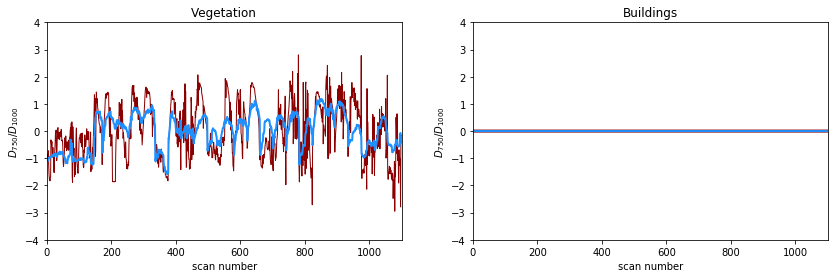

In [43]:
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(14,4))

ax1.plot(D_veg,color="darkred",lw=1)
ax1.plot(predv,color="dodgerblue",lw=2)
ax1.set_ylim(-4,4)
ax1.set_xlim(0,predv.size)
ax1.set_xlabel("scan number")
#ax1.set_ylabel(r'$D(\lambda=0.75\mu$m$)/D(\lambda=1.0\mu$m$)$')
ax1.set_ylabel(r'$D_{750}/D_{1000}$')
ax1.set_title('Vegetation')

ax2.plot(D_bld,color="darkred",lw=3)
ax2.plot(predb,color="dodgerblue",lw=2)
ax2.set_ylim(-4,4)
ax2.set_xlim(0,predb.size)
ax2.set_xlabel("scan number")
ax2.set_ylabel(r'$D_{750}/D_{1000}$')
ax2.set_title('Buildings')

plt.show()

### Maximum Likelihood Estimation with brightness

In [44]:
def log_prior(theta):
    beta_o3, beta_pm25, beta_temps, beta_humid, alpha, eps = theta
    if eps <= 0:
        return -np.inf
    return 0.0

def log_likelihood(theta, o3, pm25, temps, humid, y):
    beta_o3, beta_pm25, beta_temps, beta_humid, alpha, eps = theta
    model = beta_o3 * o3 + beta_pm25 * pm25 + beta_temps * temps + beta_humid * humid + alpha
    denom = eps ** 2
    lp = -0.5 * sum(((y - model) ** 2) / denom + np.log(denom) + np.log(2 * np.pi))
    return lp

def log_probability(theta, o3, pm25, temps, humid, y):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, o3, pm25, temps, humid, y)

In [45]:
# -- obtaining uncertainty for brightness

diffv = D_veg[1:] - D_veg[:-1]
verr = diffv.std()/np.sqrt(2.0)
print("error in vegetation brightness = ", verr)

diffb = D_bld[1:] - D_bld[:-1]
berr = diffb.std()/np.sqrt(2.0)
print("error in building brightness = ", berr)

error in vegetation brightness =  0.46058373375396044
error in building brightness =  1.0586041910926601e-16


In [47]:
# -- obtaining uncertainty for air quality

templates  = aq_opth1
diff_air = templates[1:] - templates[:-1]
air_err = diff_air.std(0)/np.sqrt(2.0)
print("errors in air quality = ", air_err)

errors in air quality =  [0.17136478 0.21631062 0.12425874 0.11580156 0.        ]


In [48]:
# -- numerical optimum of likelihood function

def MaxLikFunc(Diff_ratio, AQ, sol, err, random_seed=314):
    np.random.seed(random_seed)
    nll = lambda *args: -log_likelihood(*args)
    initial = np.append(sol[0], err)
    result = minimize(nll, initial, args=(AQ[:,0], AQ[:,1], AQ[:,2],
                                            AQ[:,3], Diff_ratio))
    beta_o3, beta_pm25, beta_temps, beta_humid, alpha, epsilon = result.x

    print("w_o3    = {0:.5f}".format(beta_o3))
    print("w_pm25  = {0:.5f}".format(beta_pm25))
    print("w_temps = {0:.5f}".format(beta_temps))
    print("w_humid = {0:.5f}".format(beta_humid))
    print("b       = {0:.5f}".format(alpha))
    print("e       = {0:.5f}".format(epsilon))
    
    return result

In [49]:
print("Maximum likelihood estimates for Vegetation:")
resultv = MaxLikFunc(D_veg, aq_opth1, solv, verr, random_seed=314)
print("")
print("Maximum likelihood estimates for Buildings:")
resultb = MaxLikFunc(D_bld, aq_opth1, solb, berr, random_seed=413)

Maximum likelihood estimates for Vegetation:
w_o3    = 0.20237
w_pm25  = -0.21658
w_temps = 0.26038
w_humid = -0.32643
b       = 0.00000
e       = 0.76854

Maximum likelihood estimates for Buildings:
w_o3    = -0.00000
w_pm25  = -0.00000
w_temps = 0.00000
w_humid = 0.00000
b       = 0.00000
e       = 0.00000


### MCMC

In [50]:
nwalkers, ndim = 50, 6
pv0 = resultv.x + 1e-4 * np.random.randn(nwalkers, ndim)
pb0 = resultb.x + 1e-4 * np.random.randn(nwalkers, ndim)

In [51]:
# -- Sample the distribution using emcee
# -- start by initializing the walkers in a small Gaussian ball around the maximum likelihood result
# -- then run 5000 steps of MCMC

# -- **Vegetation**
samplerv = emcee.EnsembleSampler(nwalkers, ndim, log_probability, 
                                args=(aq_opth1[:,0], aq_opth1[:,1],
                                      aq_opth1[:,2], aq_opth1[:,3], D_veg))
posv, probv, statev = samplerv.run_mcmc(pv0, 5000)

# -- **Buildings**
samplerb = emcee.EnsembleSampler(nwalkers, ndim, log_probability, 
                                args=(aq_opth1[:,0], aq_opth1[:,1],
                                      aq_opth1[:,2], aq_opth1[:,3], D_bld))
posb, probb, stateb = samplerb.run_mcmc(pb0, 5000)

/usr/local/lib/python3.6/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


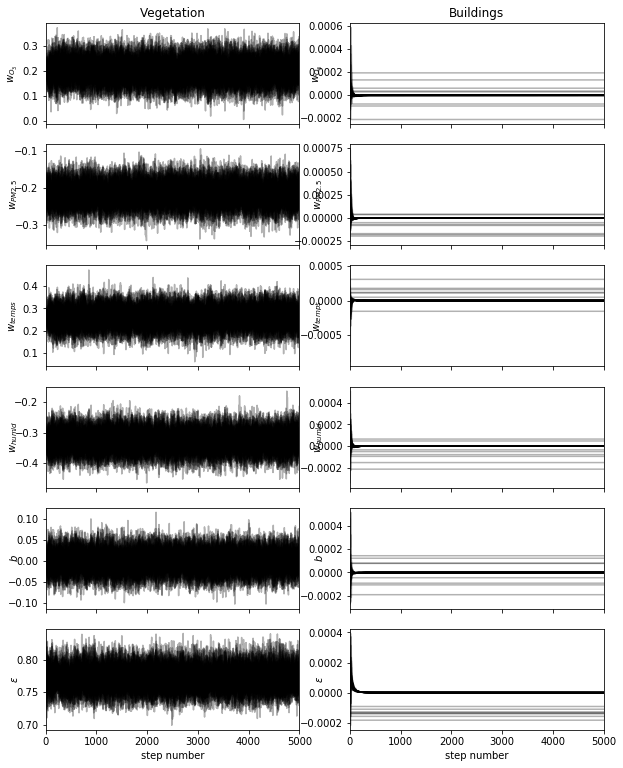

In [52]:
fig, axes = plt.subplots(ndim, 2, figsize=(10, 13), sharex=True)
labels = [r'$w_{O_3}$', r'$w_{PM2.5}$', r'$w_{temps}$', r'$w_{humid}$', r'$b$', r'$\epsilon$']
samplesv = samplerv.get_chain()
samplesb = samplerb.get_chain()
for i in range(ndim):
    ax = axes[i, 0]
    ax.plot(samplesv[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samplesv))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

for i in range(ndim):
    ax = axes[i, 1]
    ax.plot(samplesb[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samplesb))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    
axes[-1,0].set_xlabel("step number")
axes[-1,1].set_xlabel("step number")
axes[0,0].set_title("Vegetation")
axes[0,1].set_title("Buildings")
plt.show()

In [53]:
tau = samplerv.get_autocorr_time()
print(tau)
tau = samplerb.get_autocorr_time()
print(tau)

[67.79890743 65.45390029 63.54977799 59.12415001 63.37138672 54.38077007]


/usr/local/lib/python3.6/site-packages/emcee/autocorr.py:36: RuntimeWarning: invalid value encountered in true_divide
  acf /= acf[0]
/usr/local/lib/python3.6/site-packages/emcee/autocorr.py:41: RuntimeWarning: invalid value encountered in less
  m = np.arange(len(taus)) < c * taus


[nan nan nan nan nan nan]


/usr/local/lib/python3.6/site-packages/emcee/autocorr.py:99: RuntimeWarning: invalid value encountered in greater
  flag = tol * tau_est > n_t


In [54]:
# -- discard initial 200 steps (~3 x tau)
# -- thin by 30 (about half the autocorrelation time)
# -- flatten chain

flat_samplesv = samplerv.get_chain(discard=200, thin=30, flat=True)
print(flat_samplesv.shape)
flat_samplesb = samplerb.get_chain(discard=200, thin=30, flat=True)
print(flat_samplesb.shape)

(8000, 6)
(8000, 6)


Vegetation


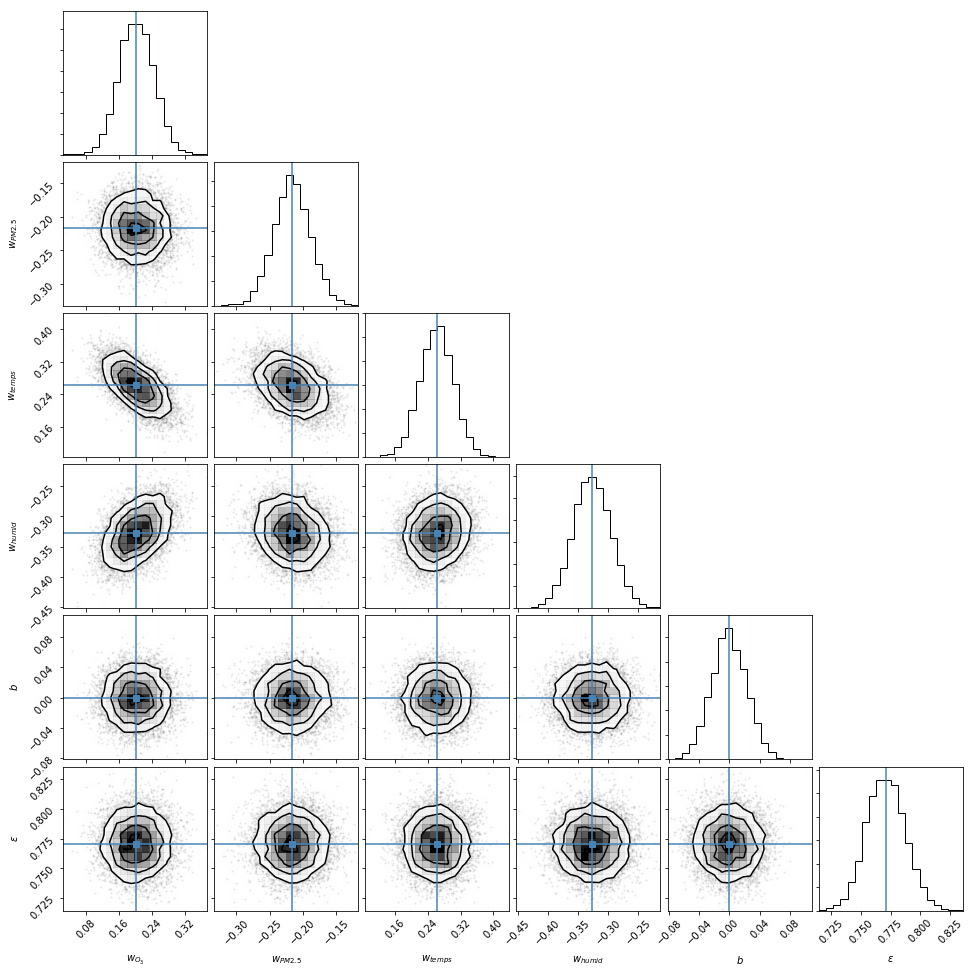

In [55]:
print("Vegetation")
fig = corner.corner(flat_samplesv, labels=labels, truths=np.median(flat_samplesv, axis=0))

Buildings


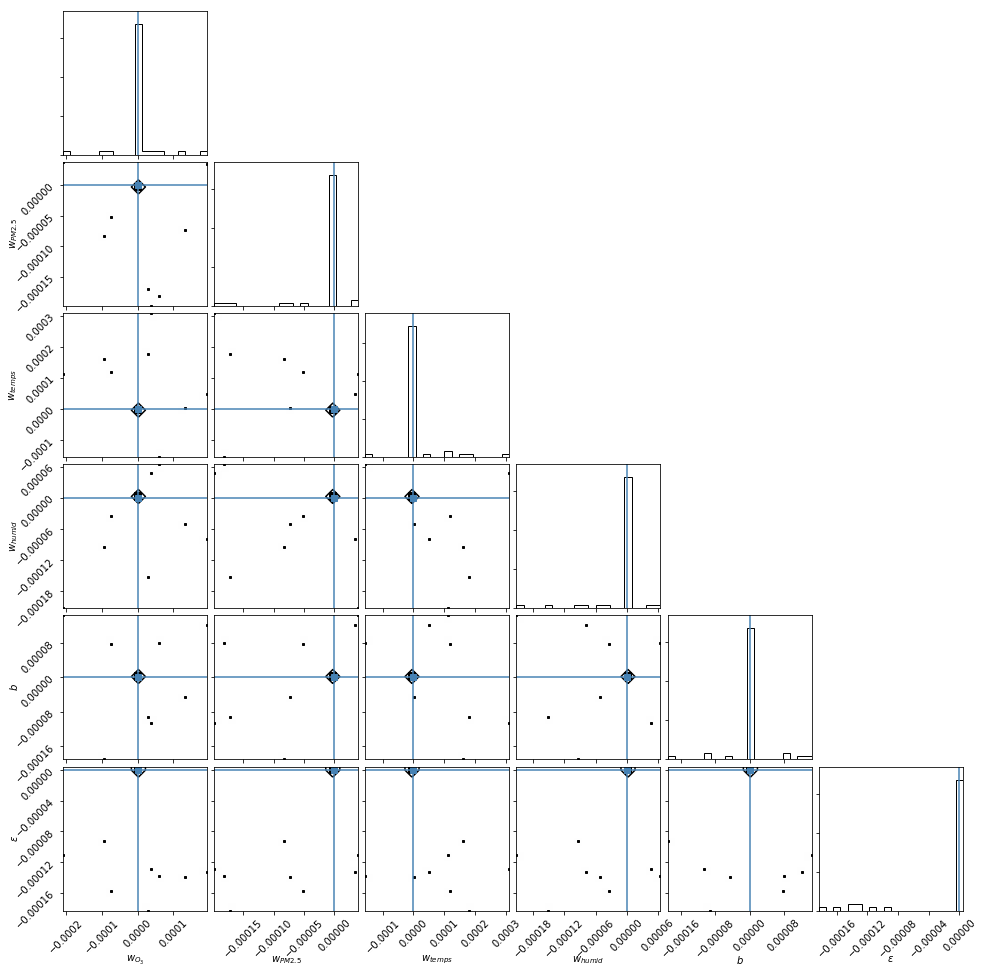

In [56]:
print("Buildings")
fig = corner.corner(flat_samplesb, labels=labels, truths=np.median(flat_samplesb, axis=0))

In [57]:
from IPython.display import display, Math

labels = ["w_{O_3}", "w_{PM2.5}", "w_{temps}", "w_{humid}", "b", "\epsilon"]
print("Vegetation")
for i in range(ndim):
    mcmc = np.percentile(flat_samplesv[:,i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.4f}_{{-{1:.4f}}}^{{{2:.4f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

print("")
print("Buildings")
for i in range(ndim):
    mcmc = np.percentile(flat_samplesb[:,i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.4f}_{{-{1:.4f}}}^{{{2:.4f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

Vegetation


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>


Buildings


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

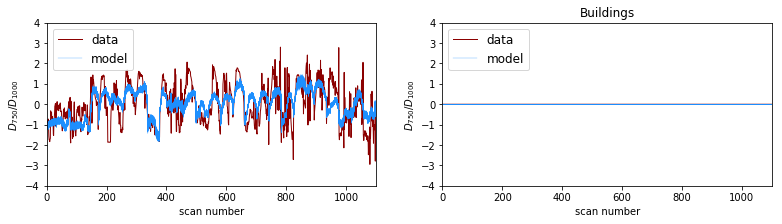

In [58]:
fig, ((ax1,ax2)) = plt.subplots(1, 2, figsize=[13,3])
linb, = ax1.plot(D_veg,color="darkred",lw=1)
inds = np.random.randint(len(flat_samplesv), size=800)
for ind in inds:
    sample = flat_samplesv[ind]
    linp, = ax1.plot(np.dot(aq_opth1, sample[:5]), color="dodgerblue", lw=0.3)
ax1.set_ylim(-4, 4)
ax1.set_xlim(0,predv.size)
ax1.set_xlabel("scan number")
ax1.set_ylabel(r'$D_{750} / D_{1000}$')
ax1.legend([linb,linp],["data","model"],loc="upper left",fontsize=12)

linb, = ax2.plot(D_bld,color="darkred",lw=1)
inds = np.random.randint(len(flat_samplesb), size=800)
for ind in inds:
    sample = flat_samplesb[ind]
    linp, = ax2.plot(np.dot(aq_opth1, sample[:5]), color="dodgerblue", lw=0.3)
ax2.set_ylim(-4, 4)
ax2.set_xlim(0,predb.size)
ax2.set_title("Buildings")
ax2.set_xlabel("scan number")
ax2.set_ylabel(r'$D_{750} / D_{1000}$')
ax2.legend([linb,linp],["data","model"],loc="upper left",fontsize=12)

plt.show()

In [59]:
# Getting 50th percentile values to use for prediction, and 16th and 84th differences for uncertainty
mvals_v = np.zeros(ndim)
err_vals_v = np.zeros(ndim)
for i in range(ndim):
    mcmc = np.percentile(flat_samplesv[:,i], [16, 50, 84])
    q = np.diff(mcmc)
    mvals_v[i] = mcmc[1]
    err_vals_v[i] = (abs(q[0]) + abs(q[1])) / 2
print(mvals_v)
print(err_vals_v)

mvals_b = np.zeros(ndim)
err_vals_b = np.zeros(ndim)
for i in range(ndim):
    mcmc = np.percentile(flat_samplesb[:,i], [16, 50, 84])
    q = np.diff(mcmc)
    mvals_b[i] = mcmc[1]
    err_vals_b[i] = (abs(q[0]) + abs(q[1])) / 2
print(mvals_b)
print(err_vals_b)

[ 2.01753520e-01 -2.16771746e-01  2.61449752e-01 -3.27363709e-01
 -7.63599836e-04  7.70663396e-01]
[0.04148145 0.0273084  0.04088901 0.03122596 0.02340525 0.0162031 ]
[ 4.39420427e-19 -3.64780865e-18  1.53203835e-18 -3.68586822e-19
 -4.23652557e-19  1.08293846e-16]
[2.92133255e-13 1.39738698e-09 1.88255685e-07 1.30573217e-11
 6.09606376e-13 7.37692740e-06]


In [60]:
def err_mult(m, merr, x, xerr):
    err = abs(m * x) * np.sqrt((merr/m)**2 + (xerr/x)**2)
    return err

In [61]:
# calculate prediction and uncertainty

pred_v = np.dot(aq_opth1, mvals_v[:5])
pred_v_err = np.zeros(pred_v.shape)
for i in range(aq_opth1.shape[0]):
    mO_err = err_mult(mvals_v[0], err_vals_v[0], aq_opth1[i,0], air_err[0])
    mp_err = err_mult(mvals_v[1], err_vals_v[1], aq_opth1[i,1], air_err[1])
    mt_err = err_mult(mvals_v[2], err_vals_v[2], aq_opth1[i,2], air_err[2])
    mh_err = err_mult(mvals_v[3], err_vals_v[3], aq_opth1[i,3], air_err[3])
    pred_v_err[i] = np.linalg.norm(np.array([mO_err, mp_err, mt_err, mh_err, err_vals_v[4]]))
    
pred_b = np.dot(aq_opth1, mvals_b[:5])
pred_b_err = np.zeros(pred_b.shape)
for i in range(aq_opth1.shape[0]):
    mO_err = err_mult(mvals_b[0], err_vals_b[0], aq_opth1[i,0], air_err[0])
    mp_err = err_mult(mvals_b[1], err_vals_b[1], aq_opth1[i,1], air_err[1])
    mt_err = err_mult(mvals_b[2], err_vals_b[2], aq_opth1[i,2], air_err[2])
    mh_err = err_mult(mvals_b[3], err_vals_b[3], aq_opth1[i,3], air_err[3])
    pred_b_err[i] = np.linalg.norm(np.array([mO_err, mp_err, mt_err, mh_err, err_vals_b[4]]))

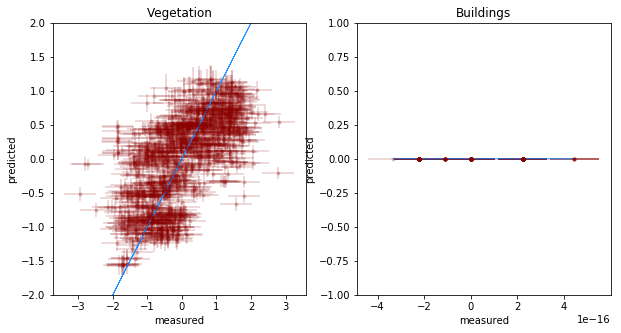

In [62]:
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=[10, 5])
linetr = ax1.errorbar(D_veg, pred_v, xerr=np.full(D_veg.shape, verr), 
                      yerr=pred_v_err, fmt='.', color="darkred", alpha=0.2)
linlin, = ax1.plot(D_veg, D_veg, color="dodgerblue", lw=0.5)
ax1.set_xlabel('measured')
ax1.set_ylabel('predicted')
ax1.set_title('Vegetation')
ax1.set_ylim(-2,2)
#ax[i].legend([linetr,linete], ['training set', 'testing set'], loc='upper left')

linetr = ax2.errorbar(D_bld, pred_b, xerr=np.full(D_bld.shape, berr), 
                      yerr=pred_b_err, fmt='.', color="darkred", alpha=0.2)
linlin, = ax2.plot(D_bld, D_bld, color="dodgerblue", lw=0.5)
ax2.set_xlabel('measured')
ax2.set_ylabel('predicted')
ax2.set_title('Buildings')
ax2.set_ylim(-1,1)

plt.show()

#### reduced chi-squared per degree of freedom

In [63]:
def redchisqg(ydata, ymod, deg=2, sd=None):
    if np.any(sd == None):
        chisq = np.sum( (ydata-ymod)**2 )
    else:
        chisq = np.sum( ((ydata - ymod) / sd)**2 )
    
    # Number of degrees of freedom assuming 2 free parameters
    nu = ydata.size - deg
    
    return chisq/nu

In [64]:
# -- standard deviation of each scan from spread of samples

veg_solns = np.zeros((flat_samplesv.shape[0], len(D_veg)))
for i in range(flat_samplesv.shape[0]):
    sample = flat_samplesv[i]
    veg_solns[i] = np.dot(aq_opth1, sample[:5])

stddev_veg = np.std(veg_solns, axis=0, ddof=1)
print(stddev_veg.min(), stddev_veg.max())

0.027490276195819504 0.09595174449468519


In [65]:
bld_solns = np.zeros((flat_samplesb.shape[0], len(D_bld)))
for i in range(flat_samplesb.shape[0]):
    sample = flat_samplesb[i]
    bld_solns[i] = np.dot(aq_opth1, sample[:5])

stddev_bld = np.std(bld_solns, axis=0, ddof=1)
print(stddev_bld.min(), stddev_bld.max())

3.9435439745096535e-05 0.0001914674373248026


In [66]:
chisq_v_opth = redchisqg(D_veg, pred_v, deg=ndim-1, sd=stddev_veg)
chisq_b_opth = redchisqg(D_bld, pred_b, deg=ndim-1, sd=stddev_bld)

print("Vegetation chi^2/dof = ", chisq_v_opth)
print("Buildings chi^2/dof  = ", chisq_b_opth)

Vegetation chi^2/dof =  313.6624757805967
Buildings chi^2/dof  =  1.8481684790737854e-24


### OLS to obtain log-likelihood scores and p-values

In [67]:
b_opth = pd.DataFrame({'D_veg': D_veg, 'D_bld': D_bld, 'o3': o3,
          'pm25': pm25, 'temps': temps, 'humid':humid})
b_opth.describe()

,D_bld,D_veg,humid,o3,pm25,temps
count,1.102000e+03,1.102000e+03,1.102000e+03,1.102000e+03,1.102000e+03,1.102000e+03
mean,2.014924e-19,2.837013e-16,2.579102e-17,-2.579102e-17,1.805372e-16,8.253128e-16
std,1.072784e-16,1.000454e+00,1.000454e+00,1.000454e+00,1.000454e+00,1.000454e+00
min,-3.330669e-16,-2.947586e+00,-1.419953e+00,-2.240910e+00,-1.844136e+00,-2.099002e+00
25%,0.000000e+00,-7.745447e-01,-8.365119e-01,-8.240281e-01,-7.389396e-01,-6.694621e-01
50%,0.000000e+00,-8.308343e-02,-2.919674e-01,1.244428e-02,-1.733975e-01,1.671688e-02
75%,0.000000e+00,8.015190e-01,7.971218e-01,5.587119e-01,5.955698e-01,6.838353e-01
max,4.440892e-16,2.802341e+00,1.730627e+00,3.290050e+00,3.139429e+00,2.437404e+00


In [68]:
# build models
modelv = sm.ols('D_veg ~ o3 + pm25 + temps + humid', data=b_opth)
modelb = sm.ols('D_bld ~ o3 + pm25 + temps + humid', data=b_opth)

# fit models to the data
resultv_opth = modelv.fit()
resultb_opth = modelb.fit()

In [69]:
# summarize model result
print("Vegetation Model")
resultv_opth.summary()

Vegetation Model


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  D_veg   R-squared:                       0.409
Model:                            OLS   Adj. R-squared:                  0.407
Method:                 Least Squares   F-statistic:                     190.1
Date:                Mon, 22 Jun 2020   Prob (F-statistic):          8.55e-124
Time:                        15:11:04   Log-Likelihood:                -1273.6
No. Observations:                1102   AIC:                             2557.
Df Residuals:                    1097   BIC:                             2582.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2.977e-16      0.023   1.28e-14      1.000      -0.046       0.046
o3             0.2024      0.042      4.807      0.000       0.120       0.285
pm25          -0.2166      0.028     -7.787      0.000      -0.271      -0.162
temps          0.2604      0.041      6.286      0.000       0.179       0.342
humid         -0.3264      0.031    -10.391      0.000      -0.388      -0.265
==============================================================================
Omnibus:                        5.900   Durbin-Watson:                   0.737
Prob(Omnibus):                  0.052   Jarque-Bera (JB):                6.333
Skew:                          -0.115   Prob(JB):                       0.0421
Kurtosis:                       3.292   Cond. No.                         3.73
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [70]:
# summarize model result
print("Buildings Model")
resultb_opth.summary()

Buildings Model


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  D_bld   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.2634
Date:                Mon, 22 Jun 2020   Prob (F-statistic):              0.902
Time:                        15:11:05   Log-Likelihood:                 38959.
No. Observations:                1102   AIC:                        -7.791e+04
Df Residuals:                    1097   BIC:                        -7.788e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2.015e-19   3.24e-18      0.062      0.950   -6.15e-18    6.55e-18
o3          -1.73e-19   5.87e-18     -0.029      0.976   -1.17e-17    1.13e-17
pm25       -3.036e-18   3.88e-18     -0.783      0.434   -1.06e-17    4.57e-18
temps        1.53e-19   5.78e-18      0.026      0.979   -1.12e-17    1.15e-17
humid        9.45e-19   4.38e-18      0.216      0.829   -7.65e-18    9.54e-18
==============================================================================
Omnibus:                       87.202   Durbin-Watson:                   1.948
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              300.019
Skew:                           0.327   Prob(JB):                     7.11e-66
Kurtosis:                       5.471   Cond. No.                         3.73
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## (2)  D(750) / D(1000)   --||vs||--   O3, PM2.5, Temps, Humid (ALL)

##       With Median Filter Applied

$brightness = w_{O3} * O_3 + w_{PM25} * PM2.5 + w_{T} * Temp + w_{H} * Humid + b + \epsilon$

In [ ]:
D_veg = sp.signal.medfilt(Dn_veg, 25)
D_bld = sp.signal.medfilt(Dn_bld, 25)

In [ ]:
solv, predv = LinLstSqrs(D_veg, aq_opth1)

In [ ]:
solb, predb = LinLstSqrs(D_bld, aq_opth1)

In [ ]:
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(14,4))

ax1.plot(D_veg,color="darkred",lw=1)
ax1.plot(predv,color="dodgerblue",lw=2)
ax1.set_ylim(-4,4)
ax1.set_xlim(0,predv.size)
ax1.set_xlabel("scan number")
#ax1.set_ylabel(r'$D(\lambda=0.75\mu$m$)/D(\lambda=1.0\mu$m$)$')
ax1.set_ylabel(r'$D_{750}/D_{1000}$')
ax1.set_title('Vegetation')

ax2.plot(D_bld,color="darkred",lw=1)
ax2.plot(predb,color="dodgerblue",lw=2)
ax2.set_ylim(-4,4)
ax2.set_xlim(0,predb.size)
ax2.set_xlabel("scan number")
ax2.set_ylabel(r'$D_{750}/D_{1000}$')
ax2.set_title('Buildings')

plt.show()

### Maximum Likelihood Estimation with brightness¶

In [ ]:
# -- obtaining uncertainty for brightness

diffv = D_veg[1:] - D_veg[:-1]
verr = diffv.std()/np.sqrt(2.0)
print("error in vegetation brightness = ", verr)

diffb = D_bld[1:] - D_bld[:-1]
berr = diffb.std()/np.sqrt(2.0)
print("error in building brightness = ", berr)

In [ ]:
# -- obtaining uncertainty for air quality

templates  = aq_opth1
diff_air = templates[1:] - templates[:-1]
air_err = diff_air.std(0)/np.sqrt(2.0)
print("errors in air qaulity = ", air_err)

In [ ]:
print("Maximum likelihood estimates for Vegetation:")
resultv = MaxLikFunc(D_veg, aq_opth1, solv, verr, random_seed=314)
print("")
print("Maximum likelihood estimates for Buildings:")
resultb = MaxLikFunc(D_bld, aq_opth1, solb, berr, random_seed=413)

### MCMC

In [ ]:
nwalkers, ndim = 50, 6
pv0 = resultv.x + 1e-4 * np.random.randn(nwalkers, ndim)
pb0 = resultb.x + 1e-4 * np.random.randn(nwalkers, ndim)

In [ ]:
# -- Sample the distribution using emcee
# -- start by initializing the walkers in a small Gaussian ball around the maximum likelihood result
# -- then run 5000 steps of MCMC

# -- **Vegetation**
samplerv = emcee.EnsembleSampler(nwalkers, ndim, log_probability, 
                                args=(aq_opth1[:,0], aq_opth1[:,1],
                                      aq_opth1[:,2], aq_opth1[:,3], D_veg))
posv, probv, statev = samplerv.run_mcmc(pv0, 5000)

# -- **Buildings**
samplerb = emcee.EnsembleSampler(nwalkers, ndim, log_probability, 
                                args=(aq_opth1[:,0], aq_opth1[:,1],
                                      aq_opth1[:,2], aq_opth1[:,3], D_bld))
posb, probb, stateb = samplerb.run_mcmc(pb0, 5000)

In [ ]:
fig, axes = plt.subplots(ndim, 2, figsize=(10, 13), sharex=True)
labels = [r'$w_{O_3}$', r'$w_{PM2.5}$', r'$w_{temps}$', r'$w_{humid}$', r'$b$', r'$\epsilon$']
samplesv = samplerv.get_chain()
samplesb = samplerb.get_chain()
for i in range(ndim):
    ax = axes[i, 0]
    ax.plot(samplesv[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samplesv))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

for i in range(ndim):
    ax = axes[i, 1]
    ax.plot(samplesb[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samplesb))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    
axes[-1,0].set_xlabel("step number")
axes[-1,1].set_xlabel("step number")
axes[0,0].set_title("Vegetation")
axes[0,1].set_title("Buildings")
plt.show()

In [ ]:
tau = samplerv.get_autocorr_time()
print(tau)
tau = samplerb.get_autocorr_time()
print(tau)

In [ ]:
# -- discard initial 200 steps (~3 x tau)
# -- thin by 30 (about half the autocorrelation time)
# -- flatten chain

flat_samplesv = samplerv.get_chain(discard=200, thin=30, flat=True)
print(flat_samplesv.shape)
flat_samplesb = samplerb.get_chain(discard=200, thin=30, flat=True)
print(flat_samplesb.shape)

In [ ]:
print("Vegetation")
fig = corner.corner(flat_samplesv, labels=labels, truths=np.median(flat_samplesv, axis=0))

In [ ]:
print("Buildings")
fig = corner.corner(flat_samplesb, labels=labels, truths=np.median(flat_samplesb, axis=0))

In [ ]:
from IPython.display import display, Math

labels = ["w_{O_3}", "w_{PM2.5}", "w_{temps}", "w_{humid}", "b", "\epsilon"]
print("Vegetation")
for i in range(ndim):
    mcmc = np.percentile(flat_samplesv[:,i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.4f}_{{-{1:.4f}}}^{{{2:.4f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

print("")
print("Buildings")
for i in range(ndim):
    mcmc = np.percentile(flat_samplesb[:,i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.4f}_{{-{1:.4f}}}^{{{2:.4f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

In [ ]:
fig, ((ax1,ax2)) = plt.subplots(1, 2, figsize=[13,3])
linb, = ax1.plot(D_veg,color="darkred",lw=1)
inds = np.random.randint(len(flat_samplesv), size=800)
for ind in inds:
    sample = flat_samplesv[ind]
    linp, = ax1.plot(np.dot(aq_opth1, sample[:5]), color="dodgerblue", lw=0.3)
ax1.set_ylim(-4, 4)
ax1.set_xlim(0,predv.size)
ax1.set_xlabel("scan number")
ax1.set_ylabel(r'$D_{750} / D_{1000}$')
ax1.legend([linb,linp],["data","model"],loc="upper left",fontsize=12)

linb, = ax2.plot(D_bld,color="darkred",lw=1)
inds = np.random.randint(len(flat_samplesb), size=800)
for ind in inds:
    sample = flat_samplesb[ind]
    linp, = ax2.plot(np.dot(aq_opth1, sample[:5]), color="dodgerblue", lw=0.3)
ax2.set_ylim(-4, 4)
ax2.set_xlim(0,predb.size)
ax2.set_title("Buildings")
ax2.set_xlabel("scan number")
ax2.set_ylabel(r'$D_{750} / D_{1000}$')
ax2.legend([linb,linp],["data","model"],loc="upper left",fontsize=12)

plt.show()

In [ ]:
# Getting 50th percentile values to use for prediction, and 16th and 84th differences for uncertainty
mvals_v = np.zeros(ndim)
err_vals_v = np.zeros(ndim)
for i in range(ndim):
    mcmc = np.percentile(flat_samplesv[:,i], [16, 50, 84])
    q = np.diff(mcmc)
    mvals_v[i] = mcmc[1]
    err_vals_v[i] = (abs(q[0]) + abs(q[1])) / 2
print(mvals_v)
print(err_vals_v)

mvals_b = np.zeros(ndim)
err_vals_b = np.zeros(ndim)
for i in range(ndim):
    mcmc = np.percentile(flat_samplesb[:,i], [16, 50, 84])
    q = np.diff(mcmc)
    mvals_b[i] = mcmc[1]
    err_vals_b[i] = (abs(q[0]) + abs(q[1])) / 2
print(mvals_b)
print(err_vals_b)

In [ ]:
pred_v = np.dot(aq_opth1, mvals_v[:5])
pred_v_err = np.zeros(pred_v.shape)
for i in range(aq_opth1.shape[0]):
    mO_err = err_mult(mvals_v[0], err_vals_v[0], aq_opth1[i,0], air_err[0])
    mp_err = err_mult(mvals_v[1], err_vals_v[1], aq_opth1[i,1], air_err[1])
    mt_err = err_mult(mvals_v[2], err_vals_v[2], aq_opth1[i,2], air_err[2])
    mh_err = err_mult(mvals_v[3], err_vals_v[3], aq_opth1[i,3], air_err[3])
    pred_v_err[i] = np.linalg.norm(np.array([mO_err, mp_err, mt_err, mh_err, err_vals_v[4]]))
    
pred_b = np.dot(aq_opth1, mvals_b[:5])
pred_b_err = np.zeros(pred_b.shape)
for i in range(aq_opth1.shape[0]):
    mO_err = err_mult(mvals_b[0], err_vals_b[0], aq_opth1[i,0], air_err[0])
    mp_err = err_mult(mvals_b[1], err_vals_b[1], aq_opth1[i,1], air_err[1])
    mt_err = err_mult(mvals_b[2], err_vals_b[2], aq_opth1[i,2], air_err[2])
    mh_err = err_mult(mvals_b[3], err_vals_b[3], aq_opth1[i,3], air_err[3])
    pred_b_err[i] = np.linalg.norm(np.array([mO_err, mp_err, mt_err, mh_err, err_vals_b[4]]))

In [ ]:
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=[10, 5])
linetr = ax1.errorbar(D_veg, pred_v, xerr=np.full(D_veg.shape, verr), 
                      yerr=pred_v_err, fmt='.', color="darkred", alpha=0.2)
linlin, = ax1.plot(D_veg, D_veg, color="dodgerblue", lw=0.5)
ax1.set_xlabel('measured')
ax1.set_ylabel('predicted')
ax1.set_title('Vegetation')
#ax1.set_ylim(-2,2)
#ax[i].legend([linetr,linete], ['training set', 'testing set'], loc='upper left')

linetr = ax2.errorbar(D_bld, pred_b, xerr=np.full(D_bld.shape, berr), 
                      yerr=pred_b_err, fmt='.', color="darkred", alpha=0.2)
linlin, = ax2.plot(D_bld, D_bld, color="dodgerblue", lw=0.5)
ax2.set_xlabel('measured')
ax2.set_ylabel('predicted')
ax2.set_title('Buildings')
#ax2.set_ylim(-1,1)

plt.show()

#### reduced chi-squared per degree of freedom

In [ ]:
# -- standard deviation of each scan from spread of samples

veg_solns = np.zeros((flat_samplesv.shape[0], len(D_veg)))
for i in range(flat_samplesv.shape[0]):
    sample = flat_samplesv[i]
    veg_solns[i] = np.dot(aq_opth1, sample[:5])

stddev_veg = np.std(veg_solns, axis=0, ddof=1)
print(stddev_veg.min(), stddev_veg.max())

In [ ]:
bld_solns = np.zeros((flat_samplesb.shape[0], len(D_bld)))
for i in range(flat_samplesb.shape[0]):
    sample = flat_samplesb[i]
    bld_solns[i] = np.dot(aq_opth1, sample[:5])

stddev_bld = np.std(bld_solns, axis=0, ddof=1)
print(stddev_bld.min(), stddev_bld.max())

In [ ]:
chisq_v_opth = redchisqg(D_veg, pred_v, deg=ndim-1, sd=stddev_veg)
chisq_b_opth = redchisqg(D_bld, pred_b, deg=ndim-1, sd=stddev_bld)

print("Vegetation chi^2/dof = ", chisq_v_opth)
print("Buildings chi^2/dof  = ", chisq_b_opth)

### OLS to obtain log-likelihood scores and p-values

In [ ]:
b_opth = pd.DataFrame({'D_veg': D_veg, 'D_bld': D_bld, 'o3': o3,
          'pm25': pm25, 'temps': temps, 'humid':humid})
b_opth.describe()

In [ ]:
# build models
modelv = sm.ols('D_veg ~ o3 + pm25 + temps + humid', data=b_opth)
modelb = sm.ols('D_bld ~ o3 + pm25 + temps + humid', data=b_opth)

# fit models to the data
resultv_opth = modelv.fit()
resultb_opth = modelb.fit()

In [ ]:
# summarize model result
print("Vegetation Model")
resultv_opth.summary()

In [ ]:
# summarize model result
print("Buildings Model")
resultb_opth.summary()

## (3)  D(750) / D(1000)   --||vs||--   O3, PM2.5, Temps, Humid (ALL)

##       With Gaussian Filter Applied

$brightness = w_{O3} * O_3 + w_{PM25} * PM2.5 + w_{T} * Temp + w_{H} * Humid + b + \epsilon$

In [ ]:
D_veg = gaussian_filter1d(Dn_veg, 1)
D_bld = gaussian_filter1d(Dn_bld, 1)

In [ ]:
solv, predv = LinLstSqrs(D_veg, aq_opth1)

In [ ]:
solb, predb = LinLstSqrs(D_bld, aq_opth1)

In [ ]:
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(14,4))

ax1.plot(D_veg,color="darkred",lw=1)
ax1.plot(predv,color="dodgerblue",lw=2)
ax1.set_ylim(-4,4)
ax1.set_xlim(0,predv.size)
ax1.set_xlabel("scan number")
#ax1.set_ylabel(r'$D(\lambda=0.75\mu$m$)/D(\lambda=1.0\mu$m$)$')
ax1.set_ylabel(r'$D_{750}/D_{1000}$')
ax1.set_title('Vegetation')

ax2.plot(D_bld,color="darkred",lw=1)
ax2.plot(predb,color="dodgerblue",lw=2)
ax2.set_ylim(-4,4)
ax2.set_xlim(0,predb.size)
ax2.set_xlabel("scan number")
ax2.set_ylabel(r'$D_{750}/D_{1000}$')
ax2.set_title('Buildings')

plt.show()

### Maximum Likelihood Estimation with brightness

In [ ]:
# -- obtaining uncertainty for brightness

diffv = D_veg[1:] - D_veg[:-1]
verr = diffv.std()/np.sqrt(2.0)
print("error in vegetation brightness = ", verr)

diffb = D_bld[1:] - D_bld[:-1]
berr = diffb.std()/np.sqrt(2.0)
print("error in building brightness = ", berr)

In [ ]:
# -- obtaining uncertainty for air quality

templates  = aq_opth1
diff_air = templates[1:] - templates[:-1]
air_err = diff_air.std(0)/np.sqrt(2.0)
print("errors in air qaulity = ", air_err)

In [ ]:
print("Maximum likelihood estimates for Vegetation:")
resultv = MaxLikFunc(D_veg, aq_opth1, solv, verr, random_seed=314)
print("")
print("Maximum likelihood estimates for Buildings:")
resultb = MaxLikFunc(D_bld, aq_opth1, solb, berr, random_seed=413)

### MCMC

In [ ]:
nwalkers, ndim = 50, 6
pv0 = resultv.x + 1e-4 * np.random.randn(nwalkers, ndim)
pb0 = resultb.x + 1e-4 * np.random.randn(nwalkers, ndim)

In [ ]:
# -- Sample the distribution using emcee
# -- start by initializing the walkers in a small Gaussian ball around the maximum likelihood result
# -- then run 5000 steps of MCMC

# -- **Vegetation**
samplerv = emcee.EnsembleSampler(nwalkers, ndim, log_probability, 
                                args=(aq_opth1[:,0], aq_opth1[:,1],
                                      aq_opth1[:,2], aq_opth1[:,3], D_veg))
posv, probv, statev = samplerv.run_mcmc(pv0, 5000)

# -- **Buildings**
samplerb = emcee.EnsembleSampler(nwalkers, ndim, log_probability, 
                                args=(aq_opth1[:,0], aq_opth1[:,1],
                                      aq_opth1[:,2], aq_opth1[:,3], D_bld))
posb, probb, stateb = samplerb.run_mcmc(pb0, 5000)

In [ ]:
fig, axes = plt.subplots(ndim, 2, figsize=(10, 13), sharex=True)
labels = [r'$w_{O_3}$', r'$w_{PM2.5}$', r'$w_{temps}$', r'$w_{humid}$', r'$b$', r'$\epsilon$']
samplesv = samplerv.get_chain()
samplesb = samplerb.get_chain()
for i in range(ndim):
    ax = axes[i, 0]
    ax.plot(samplesv[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samplesv))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

for i in range(ndim):
    ax = axes[i, 1]
    ax.plot(samplesb[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samplesb))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    
axes[-1,0].set_xlabel("step number")
axes[-1,1].set_xlabel("step number")
axes[0,0].set_title("Vegetation")
axes[0,1].set_title("Buildings")
plt.show()

In [ ]:
tau = samplerv.get_autocorr_time()
print(tau)
tau = samplerb.get_autocorr_time()
print(tau)

In [ ]:
# -- discard initial 200 steps (~3 x tau)
# -- thin by 30 (about half the autocorrelation time)
# -- flatten chain

flat_samplesv = samplerv.get_chain(discard=200, thin=30, flat=True)
print(flat_samplesv.shape)
flat_samplesb = samplerb.get_chain(discard=200, thin=30, flat=True)
print(flat_samplesb.shape)

In [ ]:
print("Vegetation")
fig = corner.corner(flat_samplesv, labels=labels, truths=np.median(flat_samplesv, axis=0))

In [ ]:
print("Buildings")
fig = corner.corner(flat_samplesb, labels=labels, truths=np.median(flat_samplesb, axis=0))

In [ ]:
from IPython.display import display, Math

labels = ["w_{O_3}", "w_{PM2.5}", "w_{temps}", "w_{humid}", "b", "\epsilon"]
print("Vegetation")
for i in range(ndim):
    mcmc = np.percentile(flat_samplesv[:,i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.4f}_{{-{1:.4f}}}^{{{2:.4f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

print("")
print("Buildings")
for i in range(ndim):
    mcmc = np.percentile(flat_samplesb[:,i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.4f}_{{-{1:.4f}}}^{{{2:.4f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

In [ ]:
fig, ((ax1,ax2)) = plt.subplots(1, 2, figsize=[13,3])
linb, = ax1.plot(D_veg,color="darkred",lw=1)
inds = np.random.randint(len(flat_samplesv), size=800)
for ind in inds:
    sample = flat_samplesv[ind]
    linp, = ax1.plot(np.dot(aq_opth1, sample[:5]), color="dodgerblue", lw=0.3)
ax1.set_ylim(-4, 4)
ax1.set_xlim(0,predv.size)
ax1.set_xlabel("scan number")
ax1.set_ylabel(r'$D_{750} / D_{1000}$')
ax1.legend([linb,linp],["data","model"],loc="upper left",fontsize=12)

linb, = ax2.plot(D_bld,color="darkred",lw=1)
inds = np.random.randint(len(flat_samplesb), size=800)
for ind in inds:
    sample = flat_samplesb[ind]
    linp, = ax2.plot(np.dot(aq_opth1, sample[:5]), color="dodgerblue", lw=0.3)
ax2.set_ylim(-4, 4)
ax2.set_xlim(0,predb.size)
ax2.set_title("Buildings")
ax2.set_xlabel("scan number")
ax2.set_ylabel(r'$D_{750} / D_{1000}$')
ax2.legend([linb,linp],["data","model"],loc="upper left",fontsize=12)

plt.show()

In [ ]:
# Getting 50th percentile values to use for prediction, and 16th and 84th differences for uncertainty
mvals_v = np.zeros(ndim)
err_vals_v = np.zeros(ndim)
for i in range(ndim):
    mcmc = np.percentile(flat_samplesv[:,i], [16, 50, 84])
    q = np.diff(mcmc)
    mvals_v[i] = mcmc[1]
    err_vals_v[i] = (abs(q[0]) + abs(q[1])) / 2
print(mvals_v)
print(err_vals_v)

mvals_b = np.zeros(ndim)
err_vals_b = np.zeros(ndim)
for i in range(ndim):
    mcmc = np.percentile(flat_samplesb[:,i], [16, 50, 84])
    q = np.diff(mcmc)
    mvals_b[i] = mcmc[1]
    err_vals_b[i] = (abs(q[0]) + abs(q[1])) / 2
print(mvals_b)
print(err_vals_b)

In [ ]:
pred_v = np.dot(aq_opth1, mvals_v[:5])
pred_v_err = np.zeros(pred_v.shape)
for i in range(aq_opth1.shape[0]):
    mO_err = err_mult(mvals_v[0], err_vals_v[0], aq_opth1[i,0], air_err[0])
    mp_err = err_mult(mvals_v[1], err_vals_v[1], aq_opth1[i,1], air_err[1])
    mt_err = err_mult(mvals_v[2], err_vals_v[2], aq_opth1[i,2], air_err[2])
    mh_err = err_mult(mvals_v[3], err_vals_v[3], aq_opth1[i,3], air_err[3])
    pred_v_err[i] = np.linalg.norm(np.array([mO_err, mp_err, mt_err, mh_err, err_vals_v[4]]))
    
pred_b = np.dot(aq_opth1, mvals_b[:5])
pred_b_err = np.zeros(pred_b.shape)
for i in range(aq_opth1.shape[0]):
    mO_err = err_mult(mvals_b[0], err_vals_b[0], aq_opth1[i,0], air_err[0])
    mp_err = err_mult(mvals_b[1], err_vals_b[1], aq_opth1[i,1], air_err[1])
    mt_err = err_mult(mvals_b[2], err_vals_b[2], aq_opth1[i,2], air_err[2])
    mh_err = err_mult(mvals_b[3], err_vals_b[3], aq_opth1[i,3], air_err[3])
    pred_b_err[i] = np.linalg.norm(np.array([mO_err, mp_err, mt_err, mh_err, err_vals_b[4]]))

In [ ]:
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=[10, 5])
linetr = ax1.errorbar(D_veg, pred_v, xerr=np.full(D_veg.shape, verr), 
                      yerr=pred_v_err, fmt='.', color="darkred", alpha=0.2)
linlin, = ax1.plot(D_veg, D_veg, color="dodgerblue", lw=0.5)
ax1.set_xlabel('measured')
ax1.set_ylabel('predicted')
ax1.set_title('Vegetation')
#ax1.set_ylim(-2,2)
#ax[i].legend([linetr,linete], ['training set', 'testing set'], loc='upper left')

linetr = ax2.errorbar(D_bld, pred_b, xerr=np.full(D_bld.shape, berr), 
                      yerr=pred_b_err, fmt='.', color="darkred", alpha=0.2)
linlin, = ax2.plot(D_bld, D_bld, color="dodgerblue", lw=0.5)
ax2.set_xlabel('measured')
ax2.set_ylabel('predicted')
ax2.set_title('Buildings')
ax2.set_ylim(-1,1)

plt.show()

#### reduced chi-squared per degree of freedom

In [ ]:
# -- standard deviation of each scan from spread of samples

veg_solns = np.zeros((flat_samplesv.shape[0], len(D_veg)))
for i in range(flat_samplesv.shape[0]):
    sample = flat_samplesv[i]
    veg_solns[i] = np.dot(aq_opth1, sample[:5])

stddev_veg = np.std(veg_solns, axis=0, ddof=1)
print(stddev_veg.min(), stddev_veg.max())

In [ ]:
bld_solns = np.zeros((flat_samplesb.shape[0], len(D_bld)))
for i in range(flat_samplesb.shape[0]):
    sample = flat_samplesb[i]
    bld_solns[i] = np.dot(aq_opth1, sample[:5])

stddev_bld = np.std(bld_solns, axis=0, ddof=1)
print(stddev_bld.min(), stddev_bld.max())

In [ ]:
chisq_v_opth = redchisqg(D_veg, pred_v, deg=ndim-1, sd=stddev_veg)
chisq_b_opth = redchisqg(D_bld, pred_b, deg=ndim-1, sd=stddev_bld)

print("Vegetation chi^2/dof = ", chisq_v_opth)
print("Buildings chi^2/dof  = ", chisq_b_opth)

#### OLS to obtain log-likelihood scores and p-values

In [ ]:
b_opth = pd.DataFrame({'D_veg': D_veg, 'D_bld': D_bld, 'o3': o3,
          'pm25': pm25, 'temps': temps, 'humid':humid})
b_opth.describe()

In [ ]:
# build models
modelv = sm.ols('D_veg ~ o3 + pm25 + temps + humid', data=b_opth)
modelb = sm.ols('D_bld ~ o3 + pm25 + temps + humid', data=b_opth)

# fit models to the data
resultv_opth = modelv.fit()
resultb_opth = modelb.fit()

In [ ]:
# summarize model result
print("Vegetation Model")
resultv_opth.summary()

In [ ]:
# summarize model result
print("Buildings Model")
resultb_opth.summary()

## (4)  D(750) / D(1000)   --||vs||--   O3, PM2.5, Temps, Humid (ALL)

##       With Sigma filtering to remove outliers

$brightness = w_{O3} * O_3 + w_{PM25} * PM2.5 + w_{T} * Temp + w_{H} * Humid + b + \epsilon$

In [ ]:
mean_b = np.mean(Dn_bld)
std_b = np.std(Dn_bld)

In [ ]:
ind3s = np.where((Dn_bld > (mean_b - 3 * std_b)) & (Dn_bld < (mean_b + 3 * std_b)))
ind2s = np.where((Dn_bld > (mean_b - 2 * std_b)) & (Dn_bld < (mean_b + 2 * std_b)))
ind1s = np.where((Dn_bld > (mean_b - 1 * std_b)) & (Dn_bld < (mean_b + 1 * std_b)))

In [ ]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(14,14))

ax1.plot(Dn_veg[ind3s[0]],color="darkred",lw=1)
#ax1.plot(predv,color="dodgerblue",lw=2)
ax1.set_ylim(-4,4)
ax1.set_xlim(0,len(ind3s[0]))
#ax1.set_xlabel("scan number")
#ax1.set_ylabel(r'$D(\lambda=0.75\mu$m$)/D(\lambda=1.0\mu$m$)$')
ax1.set_ylabel(r'$D_{750}/D_{1000}$')
ax1.set_title('Vegetation 3$\sigma$')

ax2.plot(Dn_bld[ind3s[0]],color="darkred",lw=1)
#ax2.plot(predb,color="dodgerblue",lw=2)
ax2.set_ylim(-4,4)
ax2.set_xlim(0,len(ind3s[0]))
#ax2.set_xlabel("scan number")
ax2.set_ylabel(r'$D_{750}/D_{1000}$')
ax2.set_title('Buildings 3$\sigma$')

ax3.plot(Dn_veg[ind2s[0]],color="darkred",lw=1)
#ax3.plot(predv,color="dodgerblue",lw=2)
ax3.set_ylim(-4,4)
ax3.set_xlim(0,len(ind2s[0]))
#ax3.set_xlabel("scan number")
#ax3.set_ylabel(r'$D(\lambda=0.75\mu$m$)/D(\lambda=1.0\mu$m$)$')
ax3.set_ylabel(r'$D_{750}/D_{1000}$')
ax3.set_title('Vegetation 2$\sigma$')

ax4.plot(Dn_bld[ind2s[0]],color="darkred",lw=1)
#ax4.plot(predb,color="dodgerblue",lw=2)
ax4.set_ylim(-4,4)
ax4.set_xlim(0,len(ind2s[0]))
#ax4.set_xlabel("scan number")
ax4.set_ylabel(r'$D_{750}/D_{1000}$')
ax4.set_title('Buildings 2$\sigma$')

ax5.plot(Dn_veg[ind1s[0]],color="darkred",lw=1)
#ax5.plot(predv,color="dodgerblue",lw=2)
ax5.set_ylim(-4,4)
ax5.set_xlim(0,len(ind1s[0]))
ax5.set_xlabel("scan number")
#ax5.set_ylabel(r'$D(\lambda=0.75\mu$m$)/D(\lambda=1.0\mu$m$)$')
ax5.set_ylabel(r'$D_{750}/D_{1000}$')
ax5.set_title(r'Vegetation 1$\sigma$')

ax6.plot(Dn_bld[ind1s[0]],color="darkred",lw=1)
#ax6.plot(predb,color="dodgerblue",lw=2)
ax6.set_ylim(-4,4)
ax6.set_xlim(0,len(ind1s[0]))
ax6.set_xlabel("scan number")
ax6.set_ylabel(r'$D_{750}/D_{1000}$')
ax6.set_title('Buildings  1$\sigma$')

plt.show()

In [ ]:
D_veg = Dn_veg[ind1s[0]]
D_bld = Dn_bld[ind1s[0]]
aq_opth1 = np.vstack([o3[ind1s[0]],pm25[ind1s[0]],temps[ind1s[0]]
                      ,humid[ind1s[0]],np.ones_like(o3[ind1s[0]])]).T

In [ ]:
solv, predv = LinLstSqrs(D_veg, aq_opth1)

In [ ]:
solb, predb = LinLstSqrs(D_bld, aq_opth1)

In [ ]:
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(14,4))

ax1.plot(D_veg,color="darkred",lw=1)
ax1.plot(predv,color="dodgerblue",lw=2)
ax1.set_ylim(-4,4)
ax1.set_xlim(0,predv.size)
ax1.set_xlabel("scan number")
#ax1.set_ylabel(r'$D(\lambda=0.75\mu$m$)/D(\lambda=1.0\mu$m$)$')
ax1.set_ylabel(r'$D_{750}/D_{1000}$')
ax1.set_title('Vegetation')

ax2.plot(D_bld,color="darkred",lw=1)
ax2.plot(predb,color="dodgerblue",lw=2)
ax2.set_ylim(-4,4)
ax2.set_xlim(0,predb.size)
ax2.set_xlabel("scan number")
ax2.set_ylabel(r'$D_{750}/D_{1000}$')
ax2.set_title('Buildings')

plt.show()

### Maximum Likelihood Estimation with brightness

In [ ]:
# -- obtaining uncertainty for brightness

diffv = D_veg[1:] - D_veg[:-1]
verr = diffv.std()/np.sqrt(2.0)
print("error in vegetation brightness = ", verr)

diffb = D_bld[1:] - D_bld[:-1]
berr = diffb.std()/np.sqrt(2.0)
print("error in building brightness = ", berr)

In [ ]:
# -- obtaining uncertainty for air quality

templates  = aq_opth1
diff_air = templates[1:] - templates[:-1]
air_err = diff_air.std(0)/np.sqrt(2.0)
print("errors in air qaulity = ", air_err)

In [ ]:
print("Maximum likelihood estimates for Vegetation:")
resultv = MaxLikFunc(D_veg, aq_opth1, solv, verr, random_seed=314)
print("")
print("Maximum likelihood estimates for Buildings:")
resultb = MaxLikFunc(D_bld, aq_opth1, solb, berr, random_seed=413)

### MCMC

In [ ]:
nwalkers, ndim = 50, 6
pv0 = resultv.x + 1e-4 * np.random.randn(nwalkers, ndim)
pb0 = resultb.x + 1e-4 * np.random.randn(nwalkers, ndim)

In [ ]:
# -- Sample the distribution using emcee
# -- start by initializing the walkers in a small Gaussian ball around the maximum likelihood result
# -- then run 5000 steps of MCMC

# -- **Vegetation**
samplerv = emcee.EnsembleSampler(nwalkers, ndim, log_probability, 
                                args=(aq_opth1[:,0], aq_opth1[:,1],
                                      aq_opth1[:,2], aq_opth1[:,3], D_veg))
posv, probv, statev = samplerv.run_mcmc(pv0, 5000)

# -- **Buildings**
samplerb = emcee.EnsembleSampler(nwalkers, ndim, log_probability, 
                                args=(aq_opth1[:,0], aq_opth1[:,1],
                                      aq_opth1[:,2], aq_opth1[:,3], D_bld))
posb, probb, stateb = samplerb.run_mcmc(pb0, 5000)

In [ ]:
fig, axes = plt.subplots(ndim, 2, figsize=(10, 13), sharex=True)
labels = [r'$w_{O_3}$', r'$w_{PM2.5}$', r'$w_{temps}$', r'$w_{humid}$', r'$b$', r'$\epsilon$']
samplesv = samplerv.get_chain()
samplesb = samplerb.get_chain()
for i in range(ndim):
    ax = axes[i, 0]
    ax.plot(samplesv[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samplesv))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

for i in range(ndim):
    ax = axes[i, 1]
    ax.plot(samplesb[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samplesb))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    
axes[-1,0].set_xlabel("step number")
axes[-1,1].set_xlabel("step number")
axes[0,0].set_title("Vegetation")
axes[0,1].set_title("Buildings")
plt.show()

In [ ]:
tau = samplerv.get_autocorr_time()
print(tau)
tau = samplerb.get_autocorr_time()
print(tau)

In [ ]:
# -- discard initial 200 steps (~3 x tau)
# -- thin by 30 (about half the autocorrelation time)
# -- flatten chain

flat_samplesv = samplerv.get_chain(discard=200, thin=30, flat=True)
print(flat_samplesv.shape)
flat_samplesb = samplerb.get_chain(discard=200, thin=30, flat=True)
print(flat_samplesb.shape)

In [ ]:
print("Vegetation")
fig = corner.corner(flat_samplesv, labels=labels, truths=np.median(flat_samplesv, axis=0))

In [ ]:
print("Buildings")
fig = corner.corner(flat_samplesb, labels=labels, truths=np.median(flat_samplesb, axis=0))

In [ ]:
from IPython.display import display, Math

labels = ["w_{O_3}", "w_{PM2.5}", "w_{temps}", "w_{humid}", "b", "\epsilon"]
print("Vegetation")
for i in range(ndim):
    mcmc = np.percentile(flat_samplesv[:,i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.4f}_{{-{1:.4f}}}^{{{2:.4f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

print("")
print("Buildings")
for i in range(ndim):
    mcmc = np.percentile(flat_samplesb[:,i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.4f}_{{-{1:.4f}}}^{{{2:.4f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

In [ ]:
fig, ((ax1,ax2)) = plt.subplots(1, 2, figsize=[13,3])
linb, = ax1.plot(D_veg,color="darkred",lw=1)
inds = np.random.randint(len(flat_samplesv), size=800)
for ind in inds:
    sample = flat_samplesv[ind]
    linp, = ax1.plot(np.dot(aq_opth1, sample[:5]), color="dodgerblue", lw=0.3)
ax1.set_ylim(-4, 4)
ax1.set_xlim(0,predv.size)
ax1.set_xlabel("scan number")
ax1.set_ylabel(r'$D_{750} / D_{1000}$')
ax1.legend([linb,linp],["data","model"],loc="upper left",fontsize=12)

linb, = ax2.plot(D_bld,color="darkred",lw=1)
inds = np.random.randint(len(flat_samplesb), size=800)
for ind in inds:
    sample = flat_samplesb[ind]
    linp, = ax2.plot(np.dot(aq_opth1, sample[:5]), color="dodgerblue", lw=0.3)
ax2.set_ylim(-4, 4)
ax2.set_xlim(0,predb.size)
ax2.set_title("Buildings")
ax2.set_xlabel("scan number")
ax2.set_ylabel(r'$D_{750} / D_{1000}$')
ax2.legend([linb,linp],["data","model"],loc="upper left",fontsize=12)

plt.show()

In [ ]:
# Getting 50th percentile values to use for prediction, and 16th and 84th differences for uncertainty
mvals_v = np.zeros(ndim)
err_vals_v = np.zeros(ndim)
for i in range(ndim):
    mcmc = np.percentile(flat_samplesv[:,i], [16, 50, 84])
    q = np.diff(mcmc)
    mvals_v[i] = mcmc[1]
    err_vals_v[i] = (abs(q[0]) + abs(q[1])) / 2
print(mvals_v)
print(err_vals_v)

mvals_b = np.zeros(ndim)
err_vals_b = np.zeros(ndim)
for i in range(ndim):
    mcmc = np.percentile(flat_samplesb[:,i], [16, 50, 84])
    q = np.diff(mcmc)
    mvals_b[i] = mcmc[1]
    err_vals_b[i] = (abs(q[0]) + abs(q[1])) / 2
print(mvals_b)
print(err_vals_b)

In [ ]:
pred_v = np.dot(aq_opth1, mvals_v[:5])
pred_v_err = np.zeros(pred_v.shape)
for i in range(aq_opth1.shape[0]):
    mO_err = err_mult(mvals_v[0], err_vals_v[0], aq_opth1[i,0], air_err[0])
    mp_err = err_mult(mvals_v[1], err_vals_v[1], aq_opth1[i,1], air_err[1])
    mt_err = err_mult(mvals_v[2], err_vals_v[2], aq_opth1[i,2], air_err[2])
    mh_err = err_mult(mvals_v[3], err_vals_v[3], aq_opth1[i,3], air_err[3])
    pred_v_err[i] = np.linalg.norm(np.array([mO_err, mp_err, mt_err, mh_err, err_vals_v[4]]))
    
pred_b = np.dot(aq_opth1, mvals_b[:5])
pred_b_err = np.zeros(pred_b.shape)
for i in range(aq_opth1.shape[0]):
    mO_err = err_mult(mvals_b[0], err_vals_b[0], aq_opth1[i,0], air_err[0])
    mp_err = err_mult(mvals_b[1], err_vals_b[1], aq_opth1[i,1], air_err[1])
    mt_err = err_mult(mvals_b[2], err_vals_b[2], aq_opth1[i,2], air_err[2])
    mh_err = err_mult(mvals_b[3], err_vals_b[3], aq_opth1[i,3], air_err[3])
    pred_b_err[i] = np.linalg.norm(np.array([mO_err, mp_err, mt_err, mh_err, err_vals_b[4]]))

In [ ]:
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=[10, 5])
linetr = ax1.errorbar(D_veg, pred_v, xerr=np.full(D_veg.shape, verr), 
                      yerr=pred_v_err, fmt='.', color="darkred", alpha=0.2)
linlin, = ax1.plot(D_veg, D_veg, color="dodgerblue", lw=0.5)
ax1.set_xlabel('measured')
ax1.set_ylabel('predicted')
ax1.set_title('Vegetation')
ax1.set_ylim(-2,2)
#ax[i].legend([linetr,linete], ['training set', 'testing set'], loc='upper left')

linetr = ax2.errorbar(D_bld, pred_b, xerr=np.full(D_bld.shape, berr), 
                      yerr=pred_b_err, fmt='.', color="darkred", alpha=0.2)
linlin, = ax2.plot(D_bld, D_bld, color="dodgerblue", lw=0.5)
ax2.set_xlabel('measured')
ax2.set_ylabel('predicted')
ax2.set_title('Buildings')
ax2.set_ylim(-0.1,0.5)

plt.show()

#### reduced chi-squared per degree of freedom

In [ ]:
# -- standard deviation of each scan from spread of samples

veg_solns = np.zeros((flat_samplesv.shape[0], len(D_veg)))
for i in range(flat_samplesv.shape[0]):
    sample = flat_samplesv[i]
    veg_solns[i] = np.dot(aq_opth1, sample[:5])

stddev_veg = np.std(veg_solns, axis=0, ddof=1)
print(stddev_veg.min(), stddev_veg.max())

In [ ]:
bld_solns = np.zeros((flat_samplesb.shape[0], len(D_bld)))
for i in range(flat_samplesb.shape[0]):
    sample = flat_samplesb[i]
    bld_solns[i] = np.dot(aq_opth1, sample[:5])

stddev_bld = np.std(bld_solns, axis=0, ddof=1)
print(stddev_bld.min(), stddev_bld.max())

In [ ]:
chisq_v_opth = redchisqg(D_veg, pred_v, deg=ndim-1, sd=stddev_veg)
chisq_b_opth = redchisqg(D_bld, pred_b, deg=ndim-1, sd=stddev_bld)

print("Vegetation chi^2/dof = ", chisq_v_opth)
print("Buildings chi^2/dof  = ", chisq_b_opth)

#### OLS to obtain log-likelihood scores and p-values

In [ ]:
b_opth = pd.DataFrame({'D_veg': D_veg, 'D_bld': D_bld, 'o3': o3[ind1s[0]],
          'pm25': pm25[ind1s[0]], 'temps': temps[ind1s[0]], 'humid':humid[ind1s[0]]})
b_opth.describe()

In [ ]:
# build models
modelv = sm.ols('D_veg ~ o3 + pm25 + temps + humid', data=b_opth)
modelb = sm.ols('D_bld ~ o3 + pm25 + temps + humid', data=b_opth)

# fit models to the data
resultv_opth = modelv.fit()
resultb_opth = modelb.fit()

In [ ]:
# summarize model result
print("Vegetation Model")
resultv_opth.summary()

In [ ]:
# summarize model result
print("Buildings Model")
resultb_opth.summary()

## (5)  D(750) / D(1000)   --||vs||--   O3, PM2.5, Temps, Humid (ALL)

##       With Sigma filtering to remove outliers AND Median filter applied

$brightness = w_{O3} * O_3 + w_{PM25} * PM2.5 + w_{T} * Temp + w_{H} * Humid + b + \epsilon$

In [ ]:
D_veg = sp.signal.medfilt(Dn_veg[ind1s[0]], 25)
D_bld = sp.signal.medfilt(Dn_bld[ind1s[0]], 25)

In [ ]:
solv, predv = LinLstSqrs(D_veg, aq_opth1)

In [ ]:
solb, predb = LinLstSqrs(D_bld, aq_opth1)

In [ ]:
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(14,4))

ax1.plot(D_veg,color="darkred",lw=1)
ax1.plot(predv,color="dodgerblue",lw=2)
ax1.set_ylim(-4,4)
ax1.set_xlim(0,predv.size)
ax1.set_xlabel("scan number")
#ax1.set_ylabel(r'$D(\lambda=0.75\mu$m$)/D(\lambda=1.0\mu$m$)$')
ax1.set_ylabel(r'$D_{750}/D_{1000}$')
ax1.set_title('Vegetation')

ax2.plot(D_bld,color="darkred",lw=1)
ax2.plot(predb,color="dodgerblue",lw=2)
ax2.set_ylim(-4,4)
ax2.set_xlim(0,predb.size)
ax2.set_xlabel("scan number")
ax2.set_ylabel(r'$D_{750}/D_{1000}$')
ax2.set_title('Buildings')

plt.show()

### Maximum Likelihood Estimation with brightness

In [ ]:
# -- obtaining uncertainty for brightness

diffv = D_veg[1:] - D_veg[:-1]
verr = diffv.std()/np.sqrt(2.0)
print("error in vegetation brightness = ", verr)

diffb = D_bld[1:] - D_bld[:-1]
berr = diffb.std()/np.sqrt(2.0)
print("error in building brightness = ", berr)

In [ ]:
# -- obtaining uncertainty for air quality

templates  = aq_opth1
diff_air = templates[1:] - templates[:-1]
air_err = diff_air.std(0)/np.sqrt(2.0)
print("errors in air qaulity = ", air_err)

In [ ]:
print("Maximum likelihood estimates for Vegetation:")
resultv = MaxLikFunc(D_veg, aq_opth1, solv, verr, random_seed=314)
print("")
print("Maximum likelihood estimates for Buildings:")
resultb = MaxLikFunc(D_bld, aq_opth1, solb, berr, random_seed=413)

### MCMC

In [ ]:
nwalkers, ndim = 50, 6
pv0 = resultv.x + 1e-4 * np.random.randn(nwalkers, ndim)
pb0 = resultb.x + 1e-4 * np.random.randn(nwalkers, ndim)

In [ ]:
# -- Sample the distribution using emcee
# -- start by initializing the walkers in a small Gaussian ball around the maximum likelihood result
# -- then run 5000 steps of MCMC

# -- **Vegetation**
samplerv = emcee.EnsembleSampler(nwalkers, ndim, log_probability, 
                                args=(aq_opth1[:,0], aq_opth1[:,1],
                                      aq_opth1[:,2], aq_opth1[:,3], D_veg))
posv, probv, statev = samplerv.run_mcmc(pv0, 5000)

# -- **Buildings**
samplerb = emcee.EnsembleSampler(nwalkers, ndim, log_probability, 
                                args=(aq_opth1[:,0], aq_opth1[:,1],
                                      aq_opth1[:,2], aq_opth1[:,3], D_bld))
posb, probb, stateb = samplerb.run_mcmc(pb0, 5000)

In [ ]:
fig, axes = plt.subplots(ndim, 2, figsize=(10, 13), sharex=True)
labels = [r'$w_{O_3}$', r'$w_{PM2.5}$', r'$w_{temps}$', r'$w_{humid}$', r'$b$', r'$\epsilon$']
samplesv = samplerv.get_chain()
samplesb = samplerb.get_chain()
for i in range(ndim):
    ax = axes[i, 0]
    ax.plot(samplesv[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samplesv))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

for i in range(ndim):
    ax = axes[i, 1]
    ax.plot(samplesb[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samplesb))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    
axes[-1,0].set_xlabel("step number")
axes[-1,1].set_xlabel("step number")
axes[0,0].set_title("Vegetation")
axes[0,1].set_title("Buildings")
plt.show()

In [ ]:
tau = samplerv.get_autocorr_time()
print(tau)
tau = samplerb.get_autocorr_time()
print(tau)

In [ ]:
# -- discard initial 200 steps (~3 x tau)
# -- thin by 30 (about half the autocorrelation time)
# -- flatten chain

flat_samplesv = samplerv.get_chain(discard=200, thin=30, flat=True)
print(flat_samplesv.shape)
flat_samplesb = samplerb.get_chain(discard=200, thin=30, flat=True)
print(flat_samplesb.shape)

In [ ]:
print("Vegetation")
fig = corner.corner(flat_samplesv, labels=labels, truths=np.median(flat_samplesv, axis=0))

In [ ]:
print("Buildings")
fig = corner.corner(flat_samplesb, labels=labels, truths=np.median(flat_samplesb, axis=0))

In [ ]:
from IPython.display import display, Math

labels = ["w_{O_3}", "w_{PM2.5}", "w_{temps}", "w_{humid}", "b", "\epsilon"]
print("Vegetation")
for i in range(ndim):
    mcmc = np.percentile(flat_samplesv[:,i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.4f}_{{-{1:.4f}}}^{{{2:.4f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

print("")
print("Buildings")
for i in range(ndim):
    mcmc = np.percentile(flat_samplesb[:,i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.4f}_{{-{1:.4f}}}^{{{2:.4f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

In [ ]:
fig, ((ax1,ax2)) = plt.subplots(1, 2, figsize=[13,3])
linb, = ax1.plot(D_veg,color="darkred",lw=1)
inds = np.random.randint(len(flat_samplesv), size=800)
for ind in inds:
    sample = flat_samplesv[ind]
    linp, = ax1.plot(np.dot(aq_opth1, sample[:5]), color="dodgerblue", lw=0.3)
ax1.set_ylim(-4, 4)
ax1.set_xlim(0,predv.size)
ax1.set_xlabel("scan number")
ax1.set_ylabel(r'$D_{750} / D_{1000}$')
ax1.legend([linb,linp],["data","model"],loc="upper left",fontsize=12)

linb, = ax2.plot(D_bld,color="darkred",lw=1)
inds = np.random.randint(len(flat_samplesb), size=800)
for ind in inds:
    sample = flat_samplesb[ind]
    linp, = ax2.plot(np.dot(aq_opth1, sample[:5]), color="dodgerblue", lw=0.3)
ax2.set_ylim(-4, 4)
ax2.set_xlim(0,predb.size)
ax2.set_title("Buildings")
ax2.set_xlabel("scan number")
ax2.set_ylabel(r'$D_{750} / D_{1000}$')
ax2.legend([linb,linp],["data","model"],loc="upper left",fontsize=12)

plt.show()

In [ ]:
# Getting 50th percentile values to use for prediction, and 16th and 84th differences for uncertainty
mvals_v = np.zeros(ndim)
err_vals_v = np.zeros(ndim)
for i in range(ndim):
    mcmc = np.percentile(flat_samplesv[:,i], [16, 50, 84])
    q = np.diff(mcmc)
    mvals_v[i] = mcmc[1]
    err_vals_v[i] = (abs(q[0]) + abs(q[1])) / 2
print(mvals_v)
print(err_vals_v)

mvals_b = np.zeros(ndim)
err_vals_b = np.zeros(ndim)
for i in range(ndim):
    mcmc = np.percentile(flat_samplesb[:,i], [16, 50, 84])
    q = np.diff(mcmc)
    mvals_b[i] = mcmc[1]
    err_vals_b[i] = (abs(q[0]) + abs(q[1])) / 2
print(mvals_b)
print(err_vals_b)

In [ ]:
pred_v = np.dot(aq_opth1, mvals_v[:5])
pred_v_err = np.zeros(pred_v.shape)
for i in range(aq_opth1.shape[0]):
    mO_err = err_mult(mvals_v[0], err_vals_v[0], aq_opth1[i,0], air_err[0])
    mp_err = err_mult(mvals_v[1], err_vals_v[1], aq_opth1[i,1], air_err[1])
    mt_err = err_mult(mvals_v[2], err_vals_v[2], aq_opth1[i,2], air_err[2])
    mh_err = err_mult(mvals_v[3], err_vals_v[3], aq_opth1[i,3], air_err[3])
    pred_v_err[i] = np.linalg.norm(np.array([mO_err, mp_err, mt_err, mh_err, err_vals_v[4]]))
    
pred_b = np.dot(aq_opth1, mvals_b[:5])
pred_b_err = np.zeros(pred_b.shape)
for i in range(aq_opth1.shape[0]):
    mO_err = err_mult(mvals_b[0], err_vals_b[0], aq_opth1[i,0], air_err[0])
    mp_err = err_mult(mvals_b[1], err_vals_b[1], aq_opth1[i,1], air_err[1])
    mt_err = err_mult(mvals_b[2], err_vals_b[2], aq_opth1[i,2], air_err[2])
    mh_err = err_mult(mvals_b[3], err_vals_b[3], aq_opth1[i,3], air_err[3])
    pred_b_err[i] = np.linalg.norm(np.array([mO_err, mp_err, mt_err, mh_err, err_vals_b[4]]))

In [ ]:
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=[10, 5])
linetr = ax1.errorbar(D_veg, pred_v, xerr=np.full(D_veg.shape, verr), 
                      yerr=pred_v_err, fmt='.', color="darkred", alpha=0.2)
linlin, = ax1.plot(D_veg, D_veg, color="dodgerblue", lw=0.5)
ax1.set_xlabel('measured')
ax1.set_ylabel('predicted')
ax1.set_title('Vegetation')
#ax1.set_ylim(-2,2)
#ax[i].legend([linetr,linete], ['training set', 'testing set'], loc='upper left')

linetr = ax2.errorbar(D_bld, pred_b, xerr=np.full(D_bld.shape, berr), 
                      yerr=pred_b_err, fmt='.', color="darkred", alpha=0.2)
linlin, = ax2.plot(D_bld, D_bld, color="dodgerblue", lw=0.5)
ax2.set_xlabel('measured')
ax2.set_ylabel('predicted')
ax2.set_title('Buildings')
#ax2.set_ylim(-1,1)

plt.show()

In [ ]:
# -- standard deviation of each scan from spread of samples

veg_solns = np.zeros((flat_samplesv.shape[0], len(D_veg)))
for i in range(flat_samplesv.shape[0]):
    sample = flat_samplesv[i]
    veg_solns[i] = np.dot(aq_opth1, sample[:5])

stddev_veg = np.std(veg_solns, axis=0, ddof=1)
print(stddev_veg.min(), stddev_veg.max())

In [ ]:
bld_solns = np.zeros((flat_samplesb.shape[0], len(D_bld)))
for i in range(flat_samplesb.shape[0]):
    sample = flat_samplesb[i]
    bld_solns[i] = np.dot(aq_opth1, sample[:5])

stddev_bld = np.std(bld_solns, axis=0, ddof=1)
print(stddev_bld.min(), stddev_bld.max())

In [ ]:
chisq_v_opth = redchisqg(D_veg, pred_v, deg=ndim-1, sd=stddev_veg)
chisq_b_opth = redchisqg(D_bld, pred_b, deg=ndim-1, sd=stddev_bld)

print("Vegetation chi^2/dof = ", chisq_v_opth)
print("Buildings chi^2/dof  = ", chisq_b_opth)

#### OLS to obtain log-likelihood scores and p-values

In [ ]:
b_opth = pd.DataFrame({'D_veg': D_veg, 'D_bld': D_bld, 'o3': o3[ind1s[0]],
          'pm25': pm25[ind1s[0]], 'temps': temps[ind1s[0]], 'humid':humid[ind1s[0]]})
b_opth.describe()

In [ ]:
# build models
modelv = sm.ols('D_veg ~ o3 + pm25 + temps + humid', data=b_opth)
modelb = sm.ols('D_bld ~ o3 + pm25 + temps + humid', data=b_opth)

# fit models to the data
resultv_opth = modelv.fit()
resultb_opth = modelb.fit()

In [ ]:
# summarize model result
print("Vegetation Model")
resultv_opth.summary()

In [ ]:
# summarize model result
print("Buildings Model")
resultb_opth.summary()